In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [46]:
df1 = pd.read_csv('data/creditcard.csv')
df = df1.copy()
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

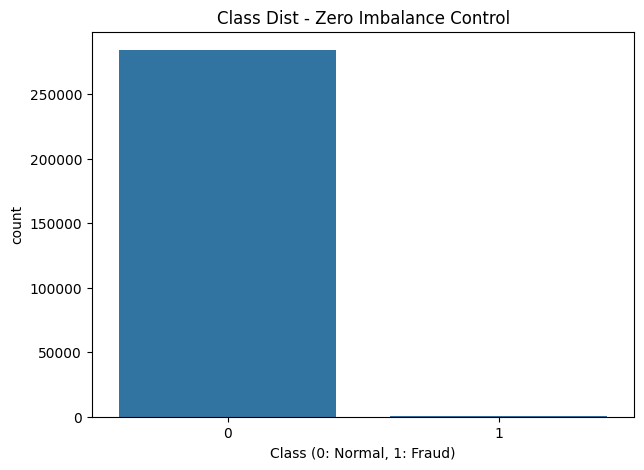

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Veri çerçevenizin 'df' olarak adlandırıldığını varsayalım
plt.figure(figsize=(7, 5))
sns.countplot(x='Class', data=df)
plt.title('Class Dist - Zero Imbalance Control')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('count')
plt.show()

We have a highly imbalanced target

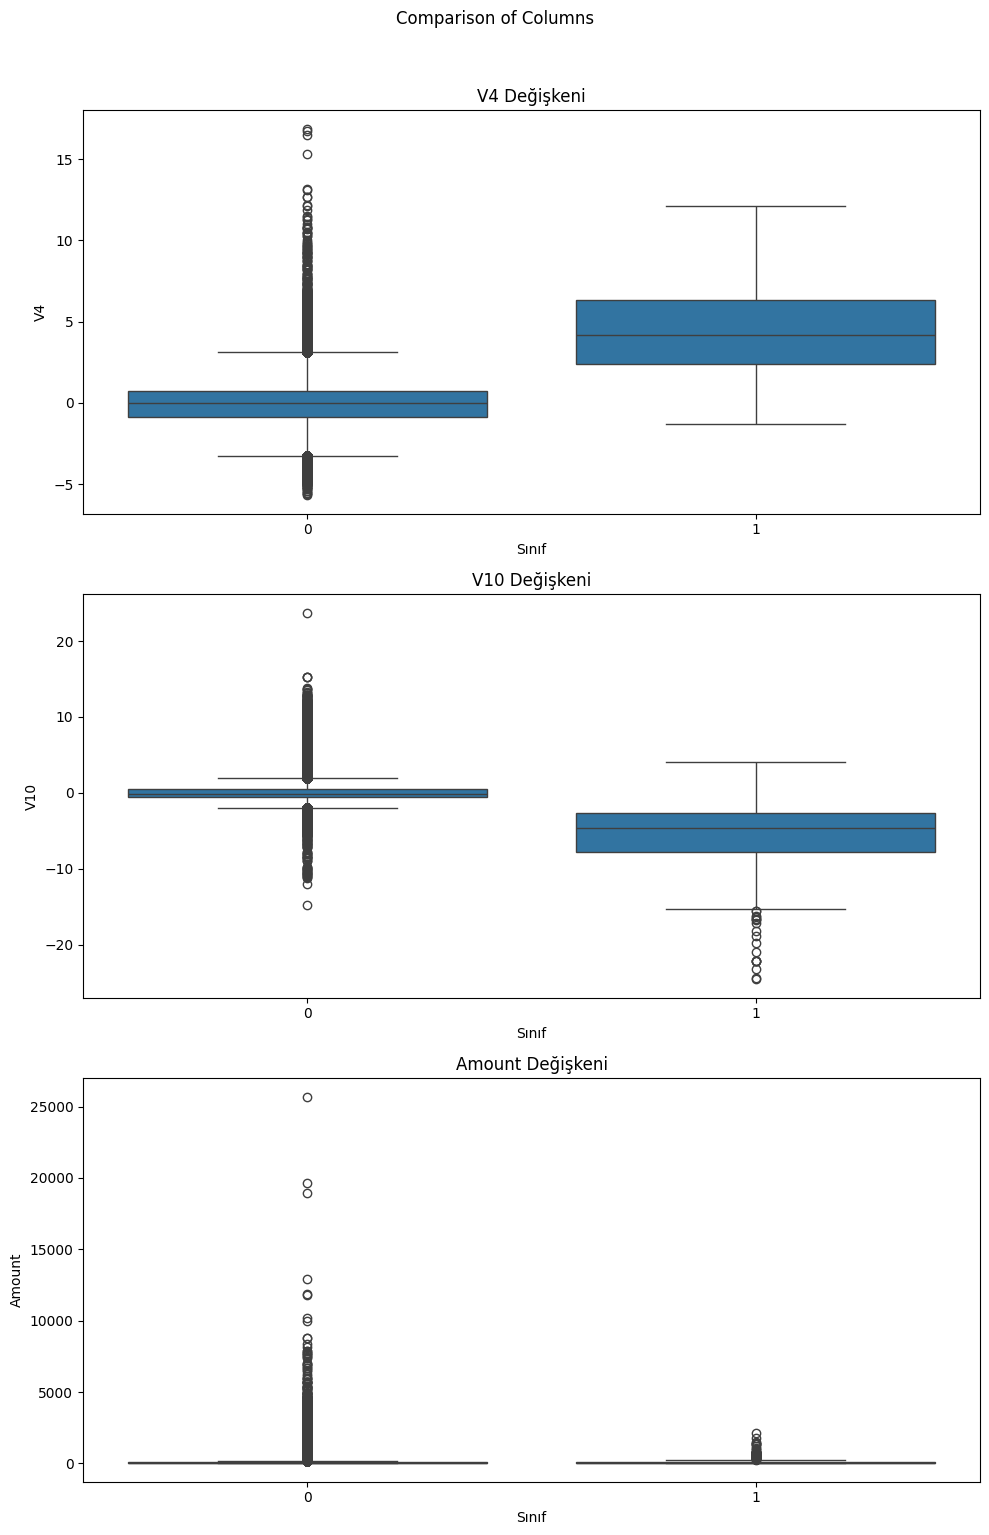

In [48]:
features_to_plot = ['V4', 'V10', 'Amount'] # Örnek olarak seçilen özellikler

fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(10, 5 * len(features_to_plot)))
plt.suptitle('Comparison of Columns', y=1.02)

for i, feature in enumerate(features_to_plot):
    sns.boxplot(x='Class', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} Değişkeni')
    axes[i].set_xlabel('Sınıf')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

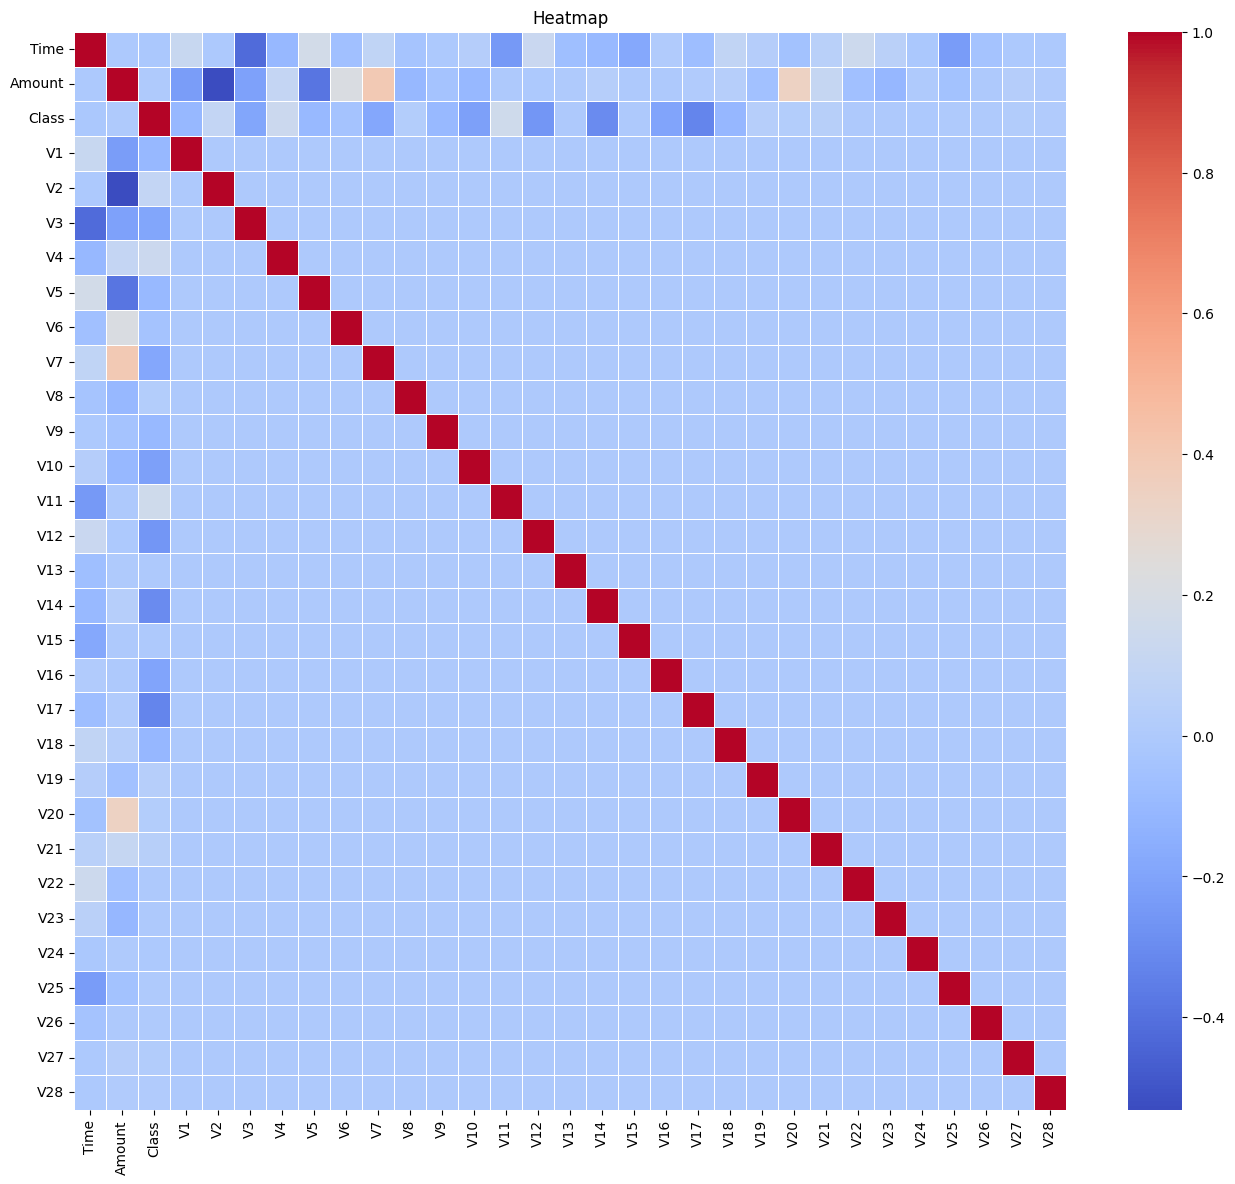

In [49]:

cols_to_correlate = ['Time', 'Amount', 'Class'] + [col for col in df.columns if col.startswith('V')]
correlation_matrix = df[cols_to_correlate].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)
plt.title('Heatmap')
plt.show()


In [50]:
from sklearn.preprocessing import RobustScaler
#since this is an imbalanced dataset, we should use robustscaler to avoid autlier ignorances
#before that i apply log normalization, because std deviation is too much even after robustscaler

In [51]:
df["Amount_log"] = np.log1p(df["Amount"])
df["Amount_scaled"] = RobustScaler().fit_transform(df[["Amount_log"]])
df["Time_log"] = np.log1p(df["Time"])
df["Time_scaled"] = RobustScaler().fit_transform(df[["Time_log"]])
scaler = RobustScaler()
features_to_scale = ['Time', 'Amount']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [52]:
time_max = df['Time'].max()
df['Hour'] = (df['Time'] / 3600) % 24
print(df["Amount"].describe())
print(time_max)
#print(df['Hour'].tail(5), df['Time'].tail(5))

count    284807.000000
mean          0.927124
std           3.495006
min          -0.307413
25%          -0.229162
50%           0.000000
75%           0.770838
max         358.683155
Name: Amount, dtype: float64
1.0350215580540185


In [53]:
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Amount_log', 'Amount_scaled', 'Time_log', 'Time_scaled',
       'Hour'],
      dtype='object')


In [54]:
X= df.drop(['Hour','Time_log','Class', 'Amount_log', 'Amount','Time'], axis = 1)
y = df['Class']
#print(X.columns, y.head())

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [56]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Original training set shape: ", Counter(y_train))
smote = SMOTE(random_state=42)
# Apply SMOTE only to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Resampled training set shape:", Counter(y_train_resampled))

Original training set shape:  Counter({0: 227451, 1: 394})
Resampled training set shape: Counter({0: 227451, 1: 227451})


In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [58]:
input_dim = X_train_resampled.shape[1]

model = Sequential([
    # Layer 1: Input Layer (implicitly defined by input_shape)
    Dense(32, activation='relu', input_shape=(input_dim,)),
    # Dropout to prevent overfitting
    Dropout(0.2), 
    
    # Layer 2: Hidden Layer
    Dense(16, activation='relu'),
    
    # Output Layer: Single unit with Sigmoid for binary probability output
    Dense(1, activation='sigmoid')
])

c:\Users\SEDA\anaconda3\envs\ml1\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
# Use the Adam optimizer with a slightly reduced learning rate (LR)
# to ensure stable training given the synthetic SMOTE data.
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Convert DataFrames to NumPy arrays for Keras
X_train_res = np.array(X_train_resampled)
y_train_res = np.array(y_train_resampled)

# Train the model
history = model.fit(
    X_train_res, 
    y_train_res, 
    epochs=50,                  # Number of passes over the data
    batch_size=256,             # Number of samples per gradient update
    validation_split=0.1,       # Use 10% of the resampled data for validation
    verbose=1                   # Show training progress
)

Epoch 1/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9664 - loss: 0.0862 - val_accuracy: 0.9943 - val_loss: 0.0305
Epoch 2/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9928 - loss: 0.0239 - val_accuracy: 0.9998 - val_loss: 0.0111
Epoch 3/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9964 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 4/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9976 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 5/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9981 - loss: 0.0078 - val_accuracy: 0.9999 - val_loss: 0.0039
Epoch 6/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9985 - loss: 0.0065 - val_accuracy: 0.9999 - val_loss: 0.0031
Epoch 7/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9988 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 8/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9988 - loss: 0.0055 - 

In [61]:
# Predict probabilities on the UNTOUCHED test data (X_test)
y_proba_nn = model.predict(X_test).flatten()

# Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred_nn = (y_proba_nn > 0.5).astype(int)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step


In [62]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print("\n--- Neural Network Classification Report (on UNTOUCHED Test Data) ---")
print(classification_report(y_test, y_pred_nn))

print("\n--- Neural Network Confusion Matrix ---")
cm_nn = confusion_matrix(y_test, y_pred_nn)
print(cm_nn)

print("\nNeural Network ROC AUC Score: %.4f" % roc_auc_score(y_test, y_proba_nn))


--- Neural Network Classification Report (on UNTOUCHED Test Data) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.85      0.81        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962


--- Neural Network Confusion Matrix ---
[[56839    25]
 [   15    83]]

Neural Network ROC AUC Score: 0.9603


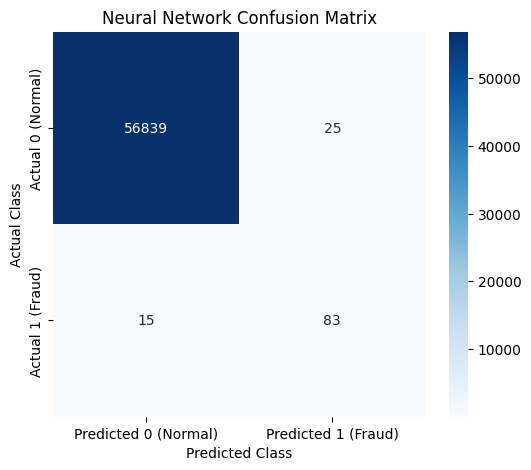

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0 (Normal)', 'Predicted 1 (Fraud)'],
            yticklabels=['Actual 0 (Normal)', 'Actual 1 (Fraud)'])
plt.title('Neural Network Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()